**Note**: run with GPU

# Intro Task, Object Localization

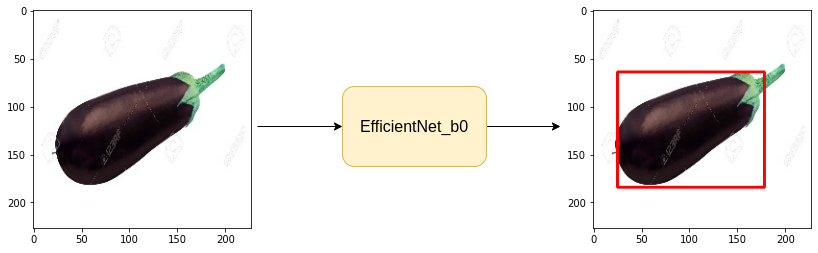

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-c7pypu_u
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-c7pypu_u
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

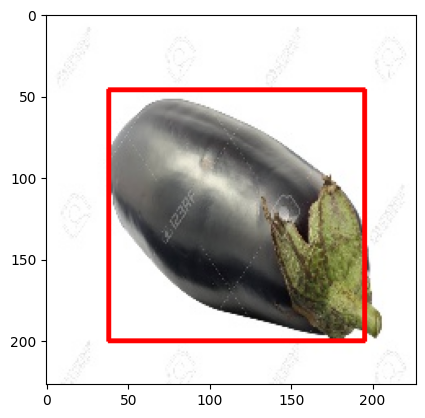

In [7]:
row = df.iloc[104]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
plt.imshow(img)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]] # Albumentation use this format

    img_path = DATA_DIR + row.img_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox, class_labels = [None]) # only localize => don't need class_labels
      img = data['image']
      bbox = data['bboxes'][0]  # get from format: [[xmin, ymin, xmax, ymax]]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0  # torch use (channel, height, weight) => shift channel-axis to 0-axis. So (h,w,c)->(c,h,w)
    bbox = torch.Tensor(bbox)

    return img,bbox

In [12]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [13]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")


Total examples in the trainset: 148
Total examples in the validset: 38


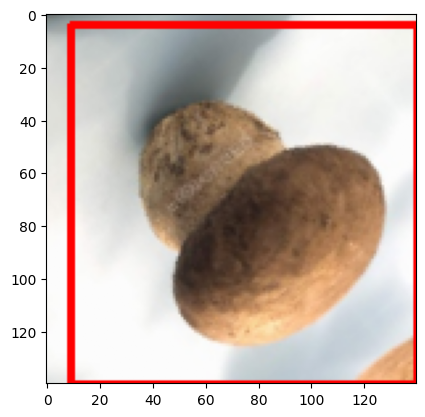

In [14]:
img, bbox = trainset[140]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (255,0,0), 2)  # cv2 use np instead of tensor
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images,bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [19]:
timm.list_models('*efficient*')

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientformerv2_l',
 'efficientformerv2_s0',
 'efficientformerv2_s1',
 'efficientformerv2_s2',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'e

In [20]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)  # output w/o softmax ???

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss

    return bboxes

In [21]:
model = ObjLocModel()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [22]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)  # batch, channel, height, width
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [23]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() # train model -> Dropout ON

  # tqdm to track batch
  for data in tqdm(dataloader):
    img,gt_bboxes = data  # gt_bboxes = ground truth
    img,gt_bboxes = img.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(img, gt_bboxes)  # model predict

    # gradient steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [24]:
def valid_fn(model,dataloader):
  total_loss = 0.0
  model.eval() # evaluate model -> Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader): # tqdm to track batch
      img, gt_bboxes = data
      img, gt_bboxes = img.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(img, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader) # avg loss

#Training Loop

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 1 train loss: 5459.764990234375 valid loss: 1435.7291666666667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 train loss: 2005.9802124023438 valid loss: 1748.8343912760417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 3 train loss: 1278.7419067382812 valid loss: 271.67047119140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 4 train loss: 841.7134338378906 valid loss: 197.97844441731772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 train loss: 563.6449249267578 valid loss: 274.17882283528644


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss: 433.373486328125 valid loss: 292.02768961588544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 7 train loss: 330.02235412597656 valid loss: 158.90067545572916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss: 235.7480239868164 valid loss: 210.33563741048178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 9 train loss: 188.80393981933594 valid loss: 125.61266326904297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss: 178.66752166748046 valid loss: 183.65342712402344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss: 146.2715576171875 valid loss: 132.8177693684896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss: 129.13775100708008 valid loss: 144.86614735921225


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss: 120.53630905151367 valid loss: 134.10751342773438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 14 train loss: 112.22903366088867 valid loss: 92.36635335286458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss: 110.41778030395508 valid loss: 98.55542755126953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss: 94.95050773620605 valid loss: 117.94319407145183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss: 90.71338272094727 valid loss: 112.07378387451172


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss: 95.27607498168945 valid loss: 128.37031046549478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss: 73.80493927001953 valid loss: 96.30117289225261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 20 train loss: 87.03262176513672 valid loss: 75.69464874267578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss: 65.23684959411621 valid loss: 82.78234736124675


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss: 66.32653846740723 valid loss: 90.0409444173177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss: 53.685783004760744 valid loss: 95.12267049153645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss: 67.1255558013916 valid loss: 83.3275515238444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss: 59.4352466583252 valid loss: 105.88964335123698


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss: 67.66951713562011 valid loss: 105.55154418945312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss: 64.26071434020996 valid loss: 81.77382405598958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss: 62.857221603393555 valid loss: 114.48143768310547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss: 57.17042465209961 valid loss: 82.46522776285808


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 30 train loss: 57.86148681640625 valid loss: 65.70575714111328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss: 52.47213630676269 valid loss: 91.69609832763672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss: 44.81163215637207 valid loss: 89.12362162272136


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss: 55.03542537689209 valid loss: 95.65822219848633


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss: 38.80168704986572 valid loss: 94.17634963989258


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss: 48.33094177246094 valid loss: 78.64330546061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss: 53.85806255340576 valid loss: 72.92519124348958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 37 train loss: 40.47898979187012 valid loss: 59.43906021118164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss: 44.587561225891115 valid loss: 85.48651631673177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss: 41.3614616394043 valid loss: 71.51644897460938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss: 43.082197189331055 valid loss: 74.10056050618489


#Inference

In [27]:
import utils  # from /content/object-localization-dataset

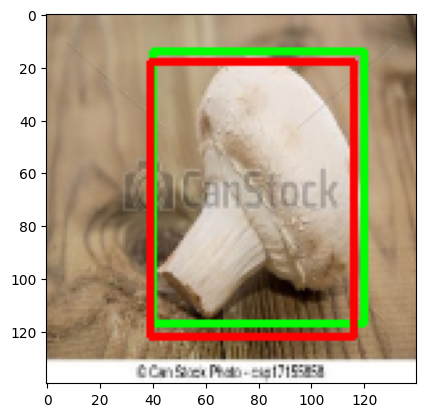

In [31]:
model.load_state_dict(torch.load('best_model.pt'))

with torch.no_grad():
  image, gt_box = validset[23] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_box, out_bbox)

Completed by keerthiveena